In [4]:
# youtube_blog_generator.py
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from youtube_transcript_api import YouTubeTranscriptApi
import streamlit as st
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display

# Load environment variables
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

# Initialize LLM
llm = ChatGroq(model="qwen-2.5-32b")

# Graph State
class State(TypedDict):
    video_url: str
    transcript: str
    blog: str
    reviewer_feedback: str
    human_feedback: str
    
 
def extract_transcript(state: State):
        """Extract transcript from the YouTube video URL."""
        try:
            # Extract video ID from URL (e.g., https://www.youtube.com/watch?v=VIDEO_ID)
            video_id = state["video_url"].split("v=")[1].split("&")[0]
            #print("video_id::",video_id)
            transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
            #print("transcript_list::", transcript_list)
            transcript = " ".join([entry["text"] for entry in transcript_list])
            print("Transcript Extracted")
            return {"transcript": transcript}
        except Exception as e:
            return {"transcript": f"Error: Could not extract transcript ({str(e)})"}

def generate_blog(state: State):
        """Generate a blog based on the transcript."""
        msg = llm.invoke(
            f"""Add a title to the blog. Make sure your blog has useful and true information about the main points of the transcript.
        Begin with a short introduction explaining the transcript. If you can, use sub sections to list important details,
        and finish your blog with a concluding sentence"""
            f"Write a blog post based on the following YouTube video transcript. "
            f"Include an introduction, key points, and a conclusion. Transcript: {state['transcript']}"
        )
        print("Blog Generated")
        return {"blog": msg.content}

def reviewer(state: State):
        """Check if the blog content is more than 200 words"""
        blog_content = state["blog"]
        #print("length is ", len(blog_content))
        print("Blog Reviewed")
        if len(blog_content) > 200 :
            return{"reviewer_feedback": True}
        else:
            return{"reviewer_feedback": False}
       
def feedback_approval(state: State):
        """Route to human feedback if accepted else end if rejected"""

        if state["reviewer_feedback"] == True:
            print("Review Accepted")
            return "Accepted"
        elif state["reviewer_feedback"] == False:
            print("Review Rejected")
            return "Rejected"

def human_feedback_fun(state: State):
        """Call generate blog to enhance the blog post based on human feedback"""
        print("Human Feedback asked")
        cont_blog = state["blog"]
        #print("blog content::::",cont_blog)
        print("length of content blog",len(cont_blog))
        if state["reviewer_feedback"] == True and len(cont_blog) < 3000:
            print("Human Feedback Accepted to extend the blog post")
            return {"human_feedback":"Accepted"}
        elif state["reviewer_feedback"] == True and len(cont_blog) > 3000:
            print("Human Feedback Rejected as no further feedback required")
            print("Final Blog:")
            print(cont_blog)
            return {"human_feedback":"Rejected"}

def human_feedback_approval(state: State):
        """ Return the next node to execute """
        print("Human Feedback conditional edge called")
        # Check if human feedback
        if state["human_feedback"] == "Accepted":
              print("Human Feedback approval accepted")
              return "Accepted"
        else:
              return "Rejected"
       
   
  


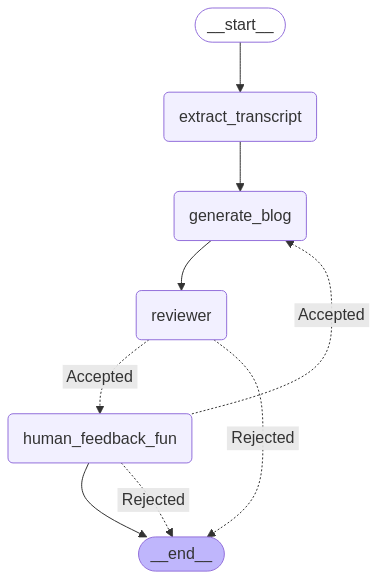

In [5]:
# Build and compile the workflow
workflow1 = StateGraph(State)
    
# Add nodes
workflow1.add_node("extract_transcript", extract_transcript)
workflow1.add_node("generate_blog", generate_blog)
workflow1.add_node("reviewer", reviewer)
workflow1.add_node("human_feedback_fun", human_feedback_fun)
    
# Add edges
workflow1.add_edge(START, "extract_transcript")
workflow1.add_edge("extract_transcript", "generate_blog")
workflow1.add_edge("generate_blog", "reviewer")
workflow1.add_conditional_edges(
    "reviewer",
    feedback_approval,
    {
        "Accepted": "human_feedback_fun",
        "Rejected": END
    }
    )
workflow1.add_edge("human_feedback_fun", END)
workflow1.add_conditional_edges(
    "human_feedback_fun",
    human_feedback_approval,
    {
        "Accepted": "generate_blog",
        "Rejected": END
    }
    )
    
# Compile
blog_agent1 = workflow1.compile()

# Show
display(Image(blog_agent1.get_graph().draw_mermaid_png()))

In [6]:
blog_agent1.invoke({"video_url":"https://www.youtube.com/watch?v=Tuw8hxrFBH8"})

Transcript Extracted
Blog Generated
Blog Reviewed
Review Accepted
Human Feedback asked
length of content blog 2897
Human Feedback Accepted to extend the blog post
Human Feedback conditional edge called
Human Feedback approval accepted
Blog Generated
Blog Reviewed
Review Accepted
Human Feedback asked
length of content blog 3404
Human Feedback Rejected as no further feedback required
Final Blog:
### Title: Navigating Life’s Uncertainties: Lessons from Steve Jobs

#### Introduction
In this blog post, we explore three inspiring stories shared by Steve Jobs, the visionary co-founder of Apple. These stories, centered around the themes of connecting the dots, overcoming failure, and embracing mortality, offer profound insights into his life experiences and the lessons he gleaned from them. This post is a deep dive into the transcript of a powerful speech, breaking down each story for a clearer understanding of Jobs’ philosophy and wisdom.

#### Connecting the Dots
Steve Jobs began his share o

{'video_url': 'https://www.youtube.com/watch?v=Tuw8hxrFBH8',
 'transcript': "today I want to tell you three stories from my life that's it no big deal just three stories [Music] the first story is about connecting the dots I dropped out of Reed College after the first six months but then stayed around as a drop-in for another 18 months or so before I really quit so why'd I drop out it started before I was born my biological mother was a young unwed graduate student and she decided to put me up for adoption she felt very strongly that I should be adopted by college graduates so everything was all set for me to be adopted at Birth by a lawyer and his wife except that when I popped out they decided at the last minute that they really wanted a girl so my parents who were on a waiting list got a call in the middle of the night asking we've got an unexpected baby boy do you want him they said of course my biological mother found out later that my mother had never graduated from college and t